**Évolution annuelle du nombre de stations Belib**

Nous utilisons les données accessibles via l'API Open Data pour explorer l'évolution des stations électriques installées au fil du temps.
En complément de cette exploration, nous employons le modèle Prophet, développé par Facebook, pour effectuer des prédictions sur l'évolution future des stations électriques. 

In [1]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def get_df_from_url(url):
    # Envoyer une requête GET à l'URL de l'API
    req = requests.get(url)
    
    # Vérifier si la requête a réussi (code de statut 200)
    if req.status_code == 200:
        wb = req.json()  # Analyser la réponse JSON
        
        # Vérifier si la réponse est directement une liste d'enregistrements
        if isinstance(wb, list):
            # Normaliser directement la liste d'enregistrements dans un DataFrame
            df = pd.json_normalize(wb)
        else:
            # Si la réponse contient une clé 'results', normaliser son contenu
            df = pd.json_normalize(wb.get("results", []))
        
        return df
    else:
        # Gérer les requêtes échouées (code de statut non-200)
        print(f"Échec de la récupération des données : {req.status_code}")
        return None

Importation des donnees via l''API de Paris Open Data

In [4]:
api_url_statique = 'https://opendata.paris.fr/api/explore/v2.1/catalog/datasets/belib-points-de-recharge-pour-vehicules-electriques-donnees-statiques/exports/json'
df_static = get_df_from_url(api_url_statique)

**Visualisation des premières lignes**

In [5]:
df_static.head()

,id_pdc_local,statut_pdc,arrondissement,id_station_local,id_station_itinerance,nom_station,code_insee_commune,implantation_station,nbre_pdc,date_maj,...,prise_type_ef,prise_type_2,prise_type_combo_ccs,prise_type_chademo,prise_type_autre,prise_type_3,horaires,raccordement,coordonneesxy.lon,coordonneesxy.lat
0,FR*V75*E9016*09*3,En service,16e Arrondissement,FR*V75*P9016*09,FRV75P901609,Paris | Rue Chardon Lagache 2,75116,Voirie,3,2024-07-01,...,True,True,True,True,False,True,24/7,Direct,2.268339,48.846760
1,FR*V75*E9018*03*1,En service,18e Arrondissement,FR*V75*P9018*03,FRV75P901803,Paris | Rue des Poissonniers 150,75118,Voirie,3,2024-07-01,...,True,True,True,True,False,True,24/7,Direct,2.352758,48.897670
2,FR*V75*E9020*05*3,En service,20e Arrondissement,FR*V75*P9020*05,FRV75P902005,Paris | Rue Louis Lumière 104,75120,Voirie,3,2024-07-01,...,True,True,True,True,False,True,24/7,Direct,2.411770,48.863766
3,FR*V75*EPX16*01*6,En service,16e Arrondissement,FR*V75*PPX16*01,FRV75PPX1601,Paris | Rue Molitor 16,75116,Voirie,6,2024-07-01,...,True,True,False,False,False,False,24/7,Direct,2.264033,48.845284
4,FR*V75*EPX02*01*1,En service,Paris centre,FR*V75*PPX02*01,FRV75PPX0201,Paris | Rue Notre-Dame des Victoires 21,75102,Voirie,4,2024-07-01,...,True,True,False,False,False,False,24/7,Direct,2.342325,48.869698


**Évolution des stations Belib**

In [6]:
# Convertir la colonne des dates en datetime
df_static['date_mise_en_service'] = pd.to_datetime(df_static['date_mise_en_service'], errors='coerce')

# Extraire l'année de la date de mise en service
df_static['year'] = df_static['date_mise_en_service'].dt.year

# Supprimer les doublons par station pour éviter les comptages multiples
df_static_unique_stations = df_static.drop_duplicates(subset=['id_station_local'])

# Agréger les données par année
df_static_grouped_year = df_static_unique_stations.groupby('year').agg(
    stations=('id_station_local', 'count')
).sort_index()

df_static_grouped_year['cumulative_stations'] = df_static_grouped_year['stations'].cumsum()

In [7]:
df_static_grouped_year

,stations,cumulative_stations
year,,
2021,355,355
2022,18,373
2023,6,379
2024,3,382


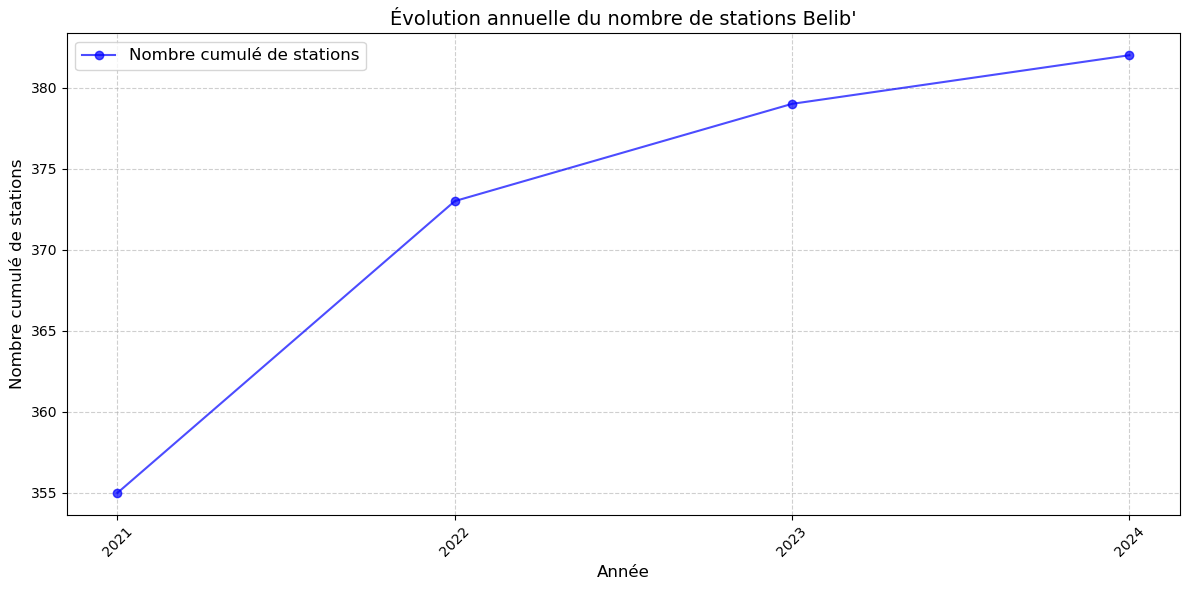

In [8]:
def plot_evolution(data, column, title, xlabel, ylabel, color='blue', marker='o', label=None):
    """
    Fonction pour tracer un graphique d'évolution annuelle basé sur des données données.

    Arguments:
    data : DataFrame
        Un DataFrame Pandas contenant les données à tracer.
    column : str
        Le nom de la colonne à tracer.
    title : str
        Le titre du graphique.
    xlabel : str
        Le label de l'axe des abscisses.
    ylabel : str
        Le label de l'axe des ordonnées.VariationVaitVVVVVSVGvVVVVASIY
    color : str, optionnel
        Couleur de la ligne du graphique. Par défaut, 'blue'.
    marker : str, optionnel
        Style du marqueur pour les points de données. Par défaut, 'o'.
    label : str, optionnel
        Label pour la légende. Par défaut, None.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(
        data.index,
        data[column],
        marker=marker,
        color=color,
        label=label if label else column,
        alpha=0.7
    )
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(data.index, data.index.astype(int), rotation=45)
    if label:
        plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


# Graphique pour le nombre cumulé de stations
plot_evolution(
    data=df_static_grouped_year,
    column='cumulative_stations',
    title="Évolution annuelle du nombre de stations Belib'",
    xlabel="Année",
    ylabel="Nombre cumulé de stations",
    color='blue',
    marker='o',
    label='Nombre cumulé de stations'
)



Ce graphique montre l'évolution annuelle des stations Belib' en région parisienne, qui ne cesse de croître au fil du temps, avec une forte possibilité de croissance future

**Prédiction de l'évolution future**

In [9]:
# Construction d'un dataset sur l'évolution du nombre de stations Belib dans le temps

df_static['date_mise_en_service'] = pd.to_datetime(df_static['date_mise_en_service'])
creation_date = df_static[['date_mise_en_service', 'id_station_local']]
creation_date = creation_date.drop_duplicates(subset=['id_station_local'])

creation_date = (creation_date.groupby('date_mise_en_service')
                     .agg({'id_station_local': 'count'})
                     .rename(columns={'id_station_local': 'stations_created'})
                     .sort_index())
                     

creation_date['cumulative_stations'] = creation_date['stations_created'].cumsum()

# Réinitialiser l'index pour faciliter les manipulations futures
creation_date.reset_index(inplace=True)

# Renommer les colonnes
creation_date.rename(columns={'date_mise_en_service': 'ds', 'cumulative_stations': 'y'}, inplace=True)

# Supprimer les fuseaux horaires des dates
creation_date['ds'] = creation_date['ds'].dt.tz_localize(None)

In [10]:
creation_date.head()

,ds,stations_created,y
0,2021-03-15 00:00:00,2,2
1,2021-03-15 14:41:48,1,3
2,2021-03-15 14:41:49,1,4
3,2021-03-15 14:41:50,3,7
4,2021-03-15 14:41:51,2,9


19:16:33 - cmdstanpy - INFO - Chain [1] start processing
19:16:33 - cmdstanpy - INFO - Chain [1] done processing


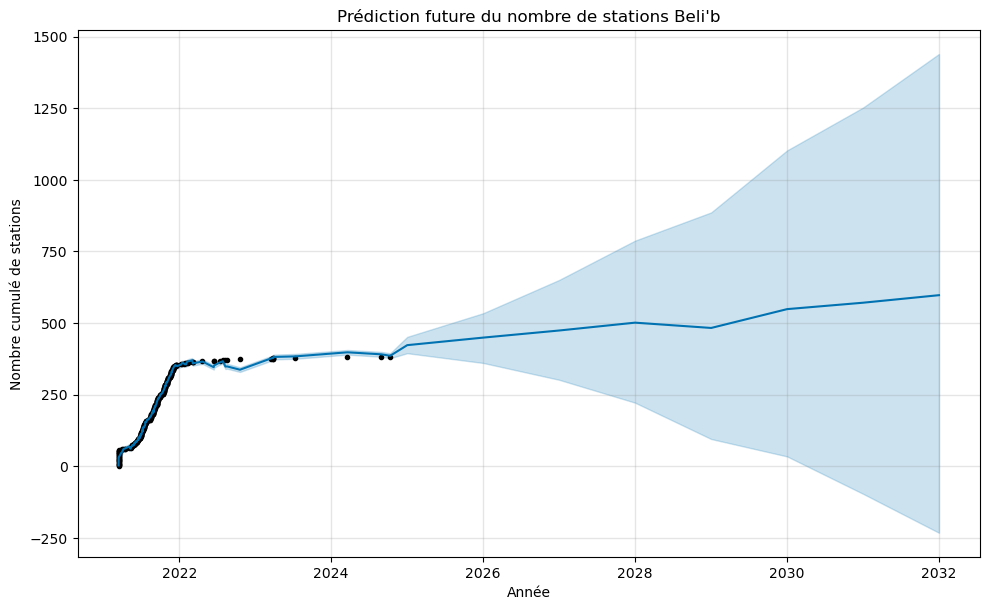

                     ds        yhat  yhat_lower   yhat_upper
350 2024-12-31 15:26:53  422.787110  394.659172   451.712952
351 2025-12-31 15:26:53  449.089627  360.616982   534.198225
352 2026-12-31 15:26:53  473.888454  301.903767   650.288360
353 2027-12-31 15:26:53  501.292278  222.005878   787.520021
354 2028-12-31 15:26:53  482.811890   95.149681   886.125221
355 2029-12-31 15:26:53  548.519249   34.395968  1102.542355
356 2030-12-31 15:26:53  570.884651  -96.061620  1252.010764
357 2031-12-31 15:26:53  597.198982 -232.103738  1439.186194


In [11]:
# Initialiser le modèle Prophet
model = Prophet()  
# Ajuster (entraîner) le modèle sur les données historiques
model.fit(creation_date)

# Prediction sur 8 années futures
future = model.make_future_dataframe(periods=8, freq='YE')  
forecast = model.predict(future)

# Visualisation des prédictions
model.plot(forecast)
plt.title("Prédiction future du nombre de stations Beli'b")
plt.xlabel("Année")
plt.ylabel("Nombre cumulé de stations")  # Étiqueter l'axe des y
plt.show()

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(8))

Les prédictions futures montrent une évolution croissante du nombre de stations dans les prochaines années, soulignant ainsi la nécessité de planifier leur répartition de manière adaptée pour répondre à cette croissance et de trouver des emplacements adéquats